In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import re
import html
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/siyu/Suicide_Detection_final1.csv')
data

,Unnamed: 0,text,class,Openness to Experience,Conscientiousness,Extraversion,Agreeableness,Neuroticism
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,51%,68%,27%,35%,67%
1,3,Am I weird I don't get affected by compliments...,non-suicide,98%,0%,1%,17%,100%
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,89%,7%,1%,11%,56%
3,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,97%,12%,22%,26%,93%
4,19,I took the rest of my sleeping pills and my pa...,suicide,98%,69%,0%,63%,90%
...,...,...,...,...,...,...,...,...
995,2521,I'm a 17 year old senior and I sometimes feel ...,suicide,75%,37%,26%,36%,85%
996,2530,I just want to go to sleep and not wake upI ha...,suicide,76%,21%,0%,17%,97%
997,2534,Help. I'm so lost.I feel so helpless despite t...,suicide,88%,25%,18%,15%,99%
998,2535,Anybody else get really scared when you get cl...,suicide,98%,41%,49%,54%,98%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Exploratory Data Analaysis & Text Preprocessing

In [ ]:
print(data.isnull().sum())

Unnamed: 0                0
text                      0
class                     0
Openness to Experience    0
Conscientiousness         0
Extraversion              0
Agreeableness             0
Neuroticism               0
dtype: int64


In [ ]:
# Adding text-length as a field in the dataset
data['text length'] = data['text'].apply(len)
print(data.head())

   Unnamed: 0                                               text        class  \
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide   
1           3  Am I weird I don't get affected by compliments...  non-suicide   
2           4  Finally 2020 is almost over... So I can never ...  non-suicide   
3          16  Everyone wants to be "edgy" and it's making me...  non-suicide   
4          19  I took the rest of my sleeping pills and my pa...      suicide   

  Openness to Experience Conscientiousness Extraversion Agreeableness  \
0                    51%               68%          27%           35%   
1                    98%                0%           1%           17%   
2                    89%                7%           1%           11%   
3                    97%               12%          22%           26%   
4                    98%               69%           0%           63%   

  Neuroticism  text length  
0         67%          715  
1        100%   

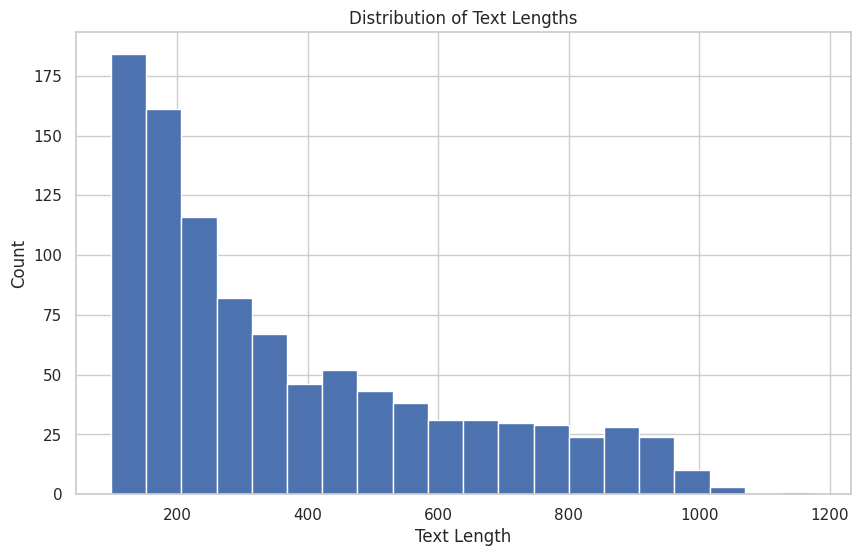

In [ ]:
#Basic visualization of data using histograms
plt.figure(figsize=(10, 6))
plt.hist(data['text length'], bins=20)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

In [ ]:
#Check text length statistics
print('Text Length Statistics:')
print(data['text length'].describe())

Text Length Statistics:
count    1000.000000
mean      372.716000
std       246.955924
min        98.000000
25%       170.000000
50%       285.000000
75%       525.500000
max      1178.000000
Name: text length, dtype: float64


<Axes: xlabel='class', ylabel='text length'>

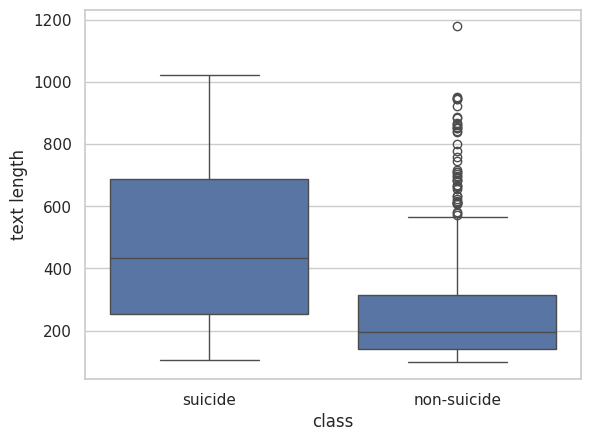

In [ ]:
# Box-plot visvualization
sns.boxplot(x='class', y='text length', data=data)

<Axes: xlabel='class', ylabel='count'>

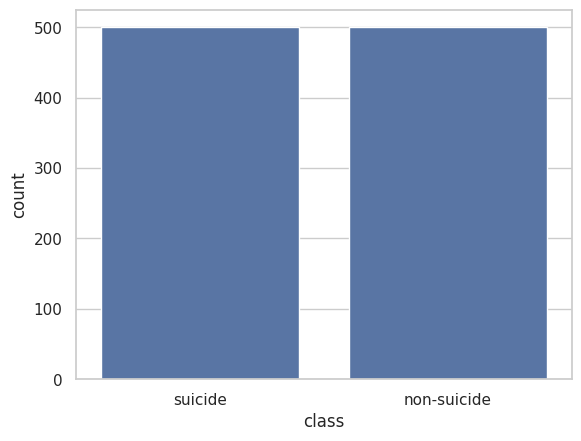

In [ ]:
#Check class distribution
sns.set_theme(style='whitegrid')
sns.countplot(data=data, x='class')

Preprocessing of text

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    my_stopwords = set(stopwords.words('english'))
    add_stopwords = ['#ff', 'ff', 'rt']
    my_stopwords.update(add_stopwords)
    tokenizer = TweetTokenizer(reduce_len=True)
    lemmatizer = WordNetLemmatizer()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = tokenizer.tokenize(text)

    # Remove stop word
    tokens = [word for word in tokens if word not in my_stopwords]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)

    return text

data['preprocessed_text'] = data.text.apply(preprocess_text)
data[['text','preprocessed_text']].head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,text,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently left wife ...
1,Am I weird I don't get affected by compliments...,weird get affected compliment coming someone k...
2,Finally 2020 is almost over... So I can never ...,finally almost never hear bad year ever swear ...
3,"Everyone wants to be ""edgy"" and it's making me...",everyone want edgy making self conscious feel ...
4,I took the rest of my sleeping pills and my pa...,took rest sleeping pill painkillersi wait end ...
5,Can you imagine getting old? Me neither.Wrinkl...,imagine getting old neither wrinkle weight gai...
6,Do you think getting hit by a train would be p...,think getting hit train would painful gun hard...
7,"death, continuedI posted here before and saw s...",death continuedi posted saw something interest...
8,Fuck the verizon smart family app I can’t even...,fuck verizon smart family app even watch porn ...
9,I’m scared. Everything just seems to be gett...,scared everything seems getting worse worse yo...


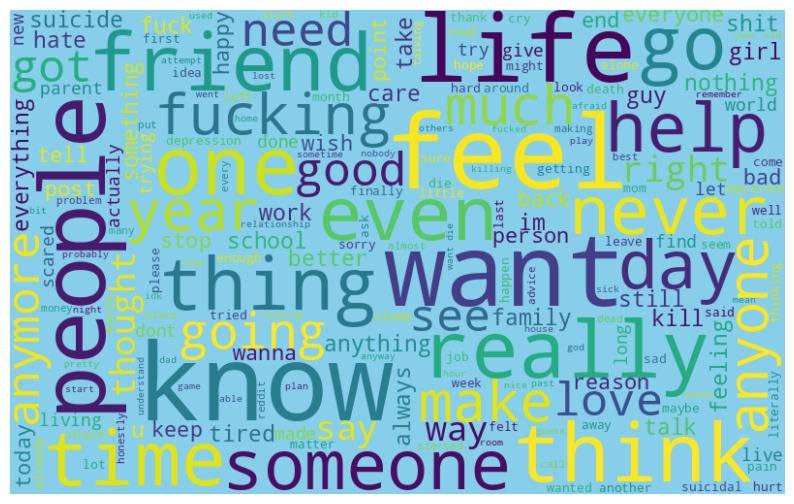

In [ ]:
# Visualize the words most commonly used in the dataset
from wordcloud import WordCloud
# imshow-Display data as an image
# interpolation - https://matplotlib.org/3.2.1/gallery/images_contours_and_fields/interpolation_methods.html
all_words = ' '.join([text for text in data['preprocessed_text'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, background_color="skyblue").generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

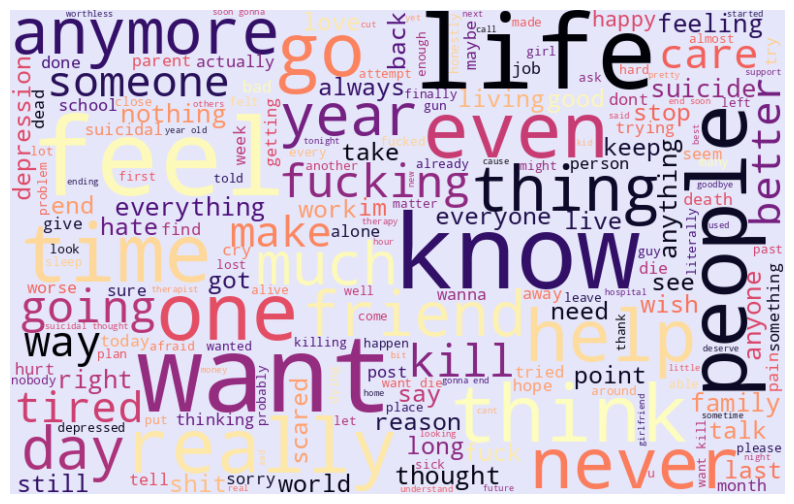

In [ ]:
# Visualize the words most commonly used in the suicide data
suicide_words = ' '.join([text for text in data['preprocessed_text'][data['class'] == 'suicide']])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110, background_color="lavender", colormap = "magma").generate(suicide_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

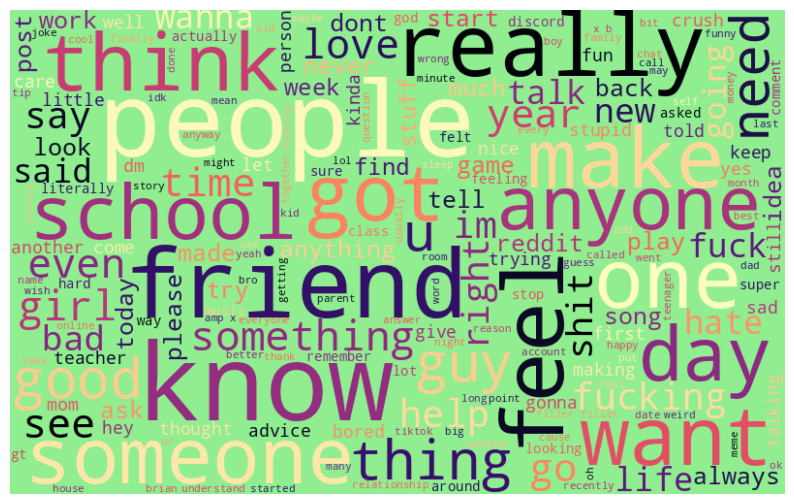

In [ ]:
# Visualize the words most commonly used in the non-suicide data
non_suicide_words = ' '.join([text for text in data['preprocessed_text'][data['class'] == 'non-suicide']])
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110, background_color="lightgreen", colormap = "magma").generate(non_suicide_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#Feature extraction & Modeling



##1. TF-IDF + XGBoost

In [ ]:
# Convert class labels into numbers
y = data['class'].map({'suicide': 1, 'non-suicide': 0})

# Train set and test set split
X_train, X_test, y_train, y_test = train_test_split(data['preprocessed_text'], y, test_size=0.2, random_state=42)


In [ ]:
# TF-IDF parameter optimization

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

parameters = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [3, 5, 10],
    'tfidf__max_features': [None, 5000, 10000]
}

vectorizer = TfidfVectorizer()
clf = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

pipeline = Pipeline([('tfidf', vectorizer), ('clf', clf)])

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters:  {'tfidf__max_df': 0.5, 'tfidf__max_features': None, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}


In [ ]:
# Retrain the model using the best parameters
best_vectorizer = TfidfVectorizer(**{k[7:]: v for k, v in grid_search.best_params_.items() if k.startswith('tfidf__')})
X_train_best = best_vectorizer.fit_transform(X_train)
X_test_best = best_vectorizer.transform(X_test)

In [ ]:
# XGBoost model
best_clf = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
best_clf.fit(X_train_best, y_train)
xgb_y_pred = best_clf.predict(X_test_best)
print('TF-IDF + XGBoost Results:')
print(classification_report(y_test, xgb_y_pred, digits=4))

TF-IDF + XGBoost Results:
              precision    recall  f1-score   support

           0     0.8830    0.8925    0.8877        93
           1     0.9057    0.8972    0.9014       107

    accuracy                         0.8950       200
   macro avg     0.8943    0.8948    0.8946       200
weighted avg     0.8951    0.8950    0.8950       200



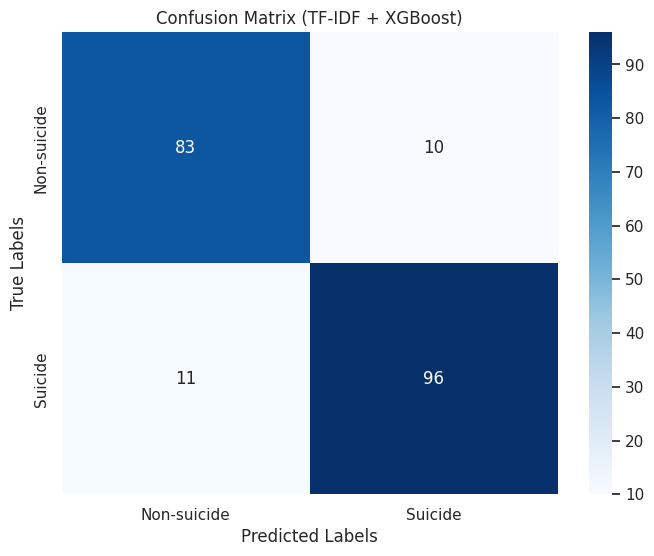

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, xgb_y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (TF-IDF + XGBoost)')
plt.show()

##2. TF-IDF + Random Forest

In [ ]:
# Random Forest model
best_rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
best_rf_clf.fit(X_train_best, y_train)
rf_y_pred = best_rf_clf.predict(X_test_best)
print('TF-IDF + Random Forest Results:')
print(classification_report(y_test, rf_y_pred, digits=4))

TF-IDF + Random Forest Results:
              precision    recall  f1-score   support

           0     0.9149    0.9247    0.9198        93
           1     0.9340    0.9252    0.9296       107

    accuracy                         0.9250       200
   macro avg     0.9244    0.9250    0.9247       200
weighted avg     0.9251    0.9250    0.9250       200



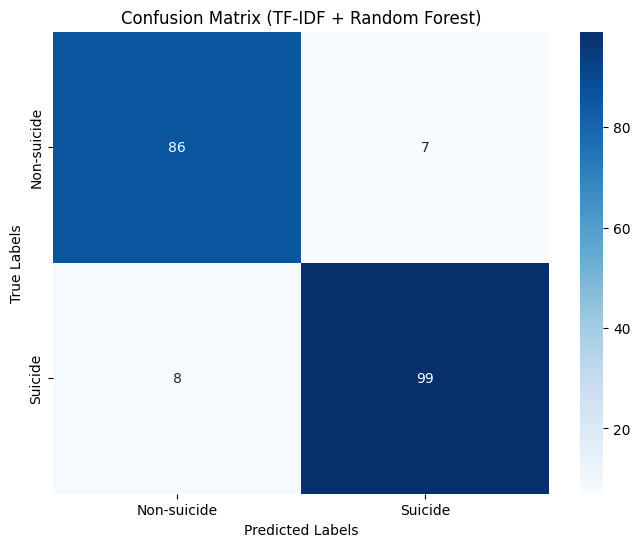

In [ ]:
# Calculate confusion matrix
rf_cm = confusion_matrix(y_test, rf_y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (TF-IDF + Random Forest)')
plt.show()

##3. Word2Vec + CNN-BiLSTM

In [ ]:
from gensim.models import KeyedVectors

# Creat word index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text into sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine the maximum sequence length
max_length = max([len(seq) for seq in X_train_seq] + [len(seq) for seq in X_test_seq])

# Fill sequence
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Load GoogleNews pre-trained word vectors
word2vec_path = '/content/drive/MyDrive/siyu/GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Get the size of the vocabulary
num_words = len(tokenizer.word_index) + 1

# Create the word embedding matrix
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Concatenate, Bidirectional, LSTM, Dense, Dropout
from keras.utils import to_categorical

y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert the labels to one-hot encoding
num_classes = 2
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

# Construct the model
embedding_dim = 300
filters = 100
kernel_size = 5
lstm_units = 100
dropout_rate = 0.3

model = Sequential()
model.add(Embedding(num_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(MaxPooling1D())
model.add(Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True)))
model.add(LSTM(lstm_units))
model.add(Dense(64, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Train the model
batch_size = 64
epochs = 5
model.fit(X_train_padded, y_train_onehot,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test_padded, y_test_onehot))

# Evaluate the model
# Make predictions on the test data
lstm_y_prob = model.predict(X_test_padded)
# Find the class index with the maximum probability
lstm_y_pred = np.argmax(lstm_y_prob, axis=1)
# Convert one-hot-encoded test labels to category indices
y_test = np.argmax(y_test_onehot, axis=1)

print('Word2Vec + CNN-BiLSTM Results:')
print(classification_report(y_test, lstm_y_pred, digits=4))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 117, 300)          1419000   
                                                                 
 conv1d_1 (Conv1D)           (None, 113, 100)          150100    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 56, 100)           0         
 g1D)                                                            
                                                                 
 bidirectional_1 (Bidirecti  (None, 56, 200)           160800    
 onal)                                                           
                                                                 
 lstm_3 (LSTM)               (None, 100)               120400    
                                                                 
 dense_2 (Dense)             (None, 64)               

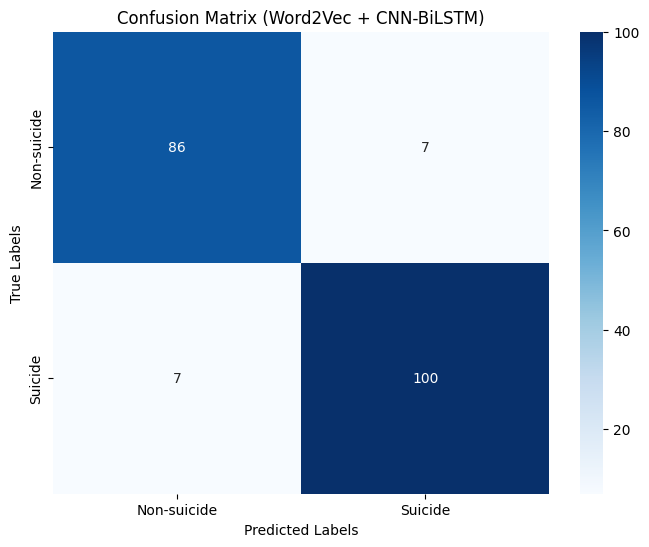

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, lstm_y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Word2Vec + CNN-BiLSTM)')
plt.show()

##4. BERT

In [ ]:
# BERT preprocessor does not require stopword, punctuation removal or tokenization, lemmatization
def preprocess_bert(text):
    tokenizer = TweetTokenizer(reduce_len=True)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Lowercasing
    text = text.lower()

    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if word not in ['"','#ff', 'ff', 'rt']]
    text = ' '.join(tokens)

    return text

data['preprocessed_text_bert'] = data.text.apply(preprocess_bert)
data[['text','preprocessed_text_bert']].head(10)

,text,preprocessed_text_bert
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently i left my ...
1,Am I weird I don't get affected by compliments...,am i weird i don't get affected by compliments...
2,Finally 2020 is almost over... So I can never ...,finally 2020 is almost over ... so i can never...
3,"Everyone wants to be ""edgy"" and it's making me...",everyone wants to be edgy and it's making me s...
4,I took the rest of my sleeping pills and my pa...,i took the rest of my sleeping pills and my pa...
5,Can you imagine getting old? Me neither.Wrinkl...,can you imagine getting old ? me neither.wrink...
6,Do you think getting hit by a train would be p...,do you think getting hit by a train would be p...
7,"death, continuedI posted here before and saw s...","death , continuedi posted here before and saw ..."
8,Fuck the verizon smart family app I can’t even...,fuck the verizon smart family app i can ’ t ev...
9,I’m scared. Everything just seems to be gett...,i ’ m scared . everything just seems to be get...


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score

texts = data['preprocessed_text_bert']
labels = data['class'].map({'suicide': 1, 'non-suicide': 0})
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# tokenize and encode sequences in the training set
encoded_data = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='max_length',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(labels)

dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = train_test_split(dataset, test_size=val_size)

train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=8
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=8
)

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False
)
optimizer = AdamW(model.parameters(), lr=1e-6)

# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(10):

    # train loop
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs.logits, b_labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} finished.")

    # validation loop
    model.eval()
    val_labels = []
    val_preds = []
    val_probs = []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # calculate probabilities for roc_auc_score
        probs = torch.nn.functional.softmax(torch.from_numpy(logits), dim=1).numpy()
        val_probs.extend(probs)

        predictions = np.argmax(logits, axis=1)
        val_labels.extend(label_ids)
        val_preds.extend(predictions)

print('BERT Results:')
print(classification_report(val_labels, val_preds, digits=4))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 finished.
Epoch 2 finished.
Epoch 3 finished.
Epoch 4 finished.
Epoch 5 finished.
Epoch 6 finished.
Epoch 7 finished.
Epoch 8 finished.
Epoch 9 finished.
Epoch 10 finished.
BERT Results:
              precision    recall  f1-score   support

           0     0.9082    0.9468    0.9271        94
           1     0.9510    0.9151    0.9327       106

    accuracy                         0.9300       200
   macro avg     0.9296    0.9310    0.9299       200
weighted avg     0.9309    0.9300    0.9301       200



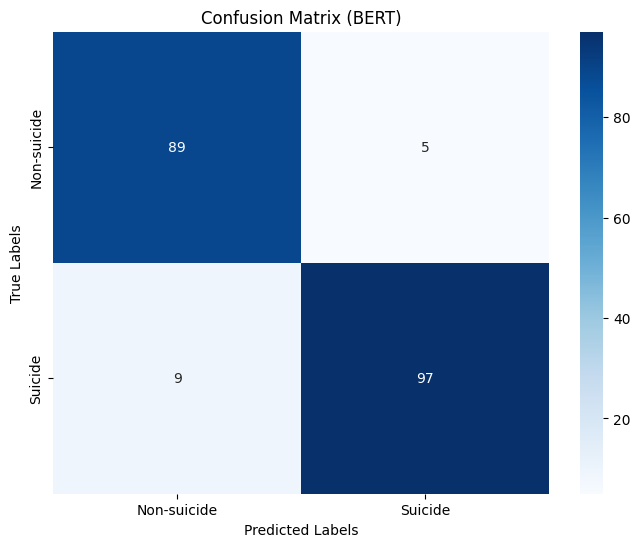

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (BERT)')
plt.show()